# WIKI-SHEAF

@ Alessio Borgi
@ Stefano Previti

### 0: IMPORTING LIBRARIES

In [2]:
!pip install requests datasets networkx matplotlib torch torch-geometric sentence-transformers torch_scatter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:0

In [4]:
### LIBRARIES NECESSARY FROM STEP 0 ON ###
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset

### LIBRARIES NECESSARY FROM STEP 2 ON ###
import torch
import random
import itertools
import networkx as nx
from matplotlib.patches import Patch
from torch_geometric.utils import from_networkx
from sklearn.feature_extraction.text import TfidfVectorizer

import os
import torch
import numpy as np
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d, Sequential, ReLU, Dropout
from sklearn.metrics import precision_score, recall_score, f1_score
from torch_geometric.nn import GCNConv, BatchNorm, GATConv, SAGEConv, GINConv

import torch.nn as nn
from torch_scatter import scatter_add
from torch_geometric.nn.norm import GraphNorm

from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses

# Only necessary if you take the dataset from the drive instead from HuggingFace.
from google.colab import drive
drive.mount('/content/drive')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



Mounted at /content/drive


### 1:  ORIGINAL DATASET

In [5]:
# Login beforehand using huggingface-cli login if necessary.
ds = load_dataset("sapienzanlp/nlp2025_hw1_cultural_dataset")
train_data = ds["train"]
validation_data = ds["validation"]

# Create Pandas Dataframes just for better analysis.
train_df = train_data.to_pandas()
validation_df = validation_data.to_pandas()


README.md:   0%|          | 0.00/2.31k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/946k [00:00<?, ?B/s]

valid.csv:   0%|          | 0.00/45.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6251 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/300 [00:00<?, ? examples/s]

In [6]:
train_df.head()

,item,name,description,type,category,subcategory,label
0,http://www.wikidata.org/entity/Q32786,916,2012 film by M. Mohanan,entity,films,film,cultural exclusive
1,http://www.wikidata.org/entity/Q371,!!!,American dance-punk band from California,entity,music,musical group,cultural representative
2,http://www.wikidata.org/entity/Q3729947,¡Soborno!,Mort & Phil comic,entity,comics and anime,comics,cultural representative
3,http://www.wikidata.org/entity/Q158611,+44,American band,entity,music,musical group,cultural representative
4,http://www.wikidata.org/entity/Q280375,1 Monk Street,"building in Monmouth, Wales",entity,architecture,building,cultural exclusive


In [7]:
validation_df.head()

,item,name,description,type,category,subcategory,label
0,http://www.wikidata.org/entity/Q15786,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",entity,sports,sports club,cultural representative
1,http://www.wikidata.org/entity/Q268530,77 Records,UK record label,entity,music,record label,cultural exclusive
2,http://www.wikidata.org/entity/Q216153,A Bug's Life,1998 animated film directed by John Lasseter a...,entity,comics and anime,animated film,cultural representative
3,http://www.wikidata.org/entity/Q593,A Gang Story,2011 film by Olivier Marchal,entity,films,film,cultural exclusive
4,http://www.wikidata.org/entity/Q192185,Aaron Copland,"American composer, composition teacher, writer...",entity,performing arts,choreographer,cultural representative


### 2: GRAPH CONSTRUCTION

In this section, we will proceed to build the big one-graph from the dataset and we will associate to them some embeddings (with different techniques). After that, we will run over them some typical Graph Models, but also more particular and difficult ones.

####2.1: (BASELINE) TF–IDF + Category/Subcategory Clique Graph

In this first **Baseline**, we represent each cultural item as a node in a **homogeneous graph**, using its name and description to build a **1 000‑dimensional TF–IDF(Term Frequency–Inverse Document Frequency) feature vector**.  **Edges** are then added by **fully connecting (“clique‐ing”)** all items that share the same high‑level category or fine‑grained subcategory, encoding cultural similarity purely via our provided taxonomy.  We also create train/validation masks on the nodes so that downstream GNNs can be trained and evaluated in a standard node‐classification setup. Notice that this is just a very basic construction that provides only a starting point before moving on to more sophisticated graph types or feature enhancements.  

--------------------------
**TF–IDF FEATURE VECTOR**

*(Reference: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)*

In this baseline graph, each node corresponds to a cultural item with two text fields: **name** and **description**.  To turn these into fixed‑length numeric features that capture the most distinctive words for each item, we compute a **TF–IDF** vector.

- **Tokenization and Vocabulary:** The *TfidfVectorizer* we employ, by default:
  - Splits each “name + description” string on whitespace and punctuation.
  - Converts all text to lowercase.
  - Builds a vocabulary of the top `max_features` $(\leq 1\,000)$ terms ranked by overall TF–IDF score.

- **Term Frequency (TF):** For a given item $d$ and term $t$, we have that this captures how often $t$ appears **within** this item’s text.
:
$$\begin{equation}
  \mathrm{TF}(t, d) \;=\; \frac{\text{count of }t\text{ in }d}{\text{total terms in }d}.
  \end{equation}
$$

- **Inverse Document Frequency (IDF):** Over the entire corpus of $N$ items  (with $\lvert\{d : t \in d\}\rvert$ being the number of items containing $t$), we have that rarer terms get a higher IDF weight.:
$$\begin{equation}
  \mathrm{IDF}(t) \;=\; \log\!\Bigl(\frac{N}{1 + \lvert\{\,d : t \in d\}\rvert}\Bigr),
  \end{equation}
$$

- **Combining TF and IDF:** The **TF–IDF** weight for term $t$ in document $d$ is:
$$\begin{equation}
  \mathrm{TF\mbox{–}IDF}(t, d) \;=\; \mathrm{TF}(t, d) \times \mathrm{IDF}(t).
  \end{equation}
$$

One can interpret this information as follows:
- **High TF–IDF** --> term is common in this item but rare across all items.
- **Low TF–IDF** --> term is either too common everywhere or too rare in this item.

--------------------------
**1. DATA PREPARATION & SPLIT**

- We begin by adding to the **train** and **validation** DataFrames, one item per row with the columns: (`item`, `name`,
 `description`, `type`, `category` and `subcategory`, `label`.
- We tag each row with a `split` column (`'train'` vs `'val'`) and then also concatenate both sets into a single DataFrame `df`.  
- We also create explicit boolean masks (`train_mask`, `val_mask`) so we can later index into our graph object for training vs validation.  

**2. BUILDING THE GRAPH TOPOLOGY**

- We instantiate an empty **NetworkX** graph `G`.  
- **Nodes** correspond one‑to‑one with rows in `df` (by integer index) and e store each node’s `category` and `subcategory` and the `train_mask`/`val_mask` flags.

- We connect nodes via **clique edges** on shared categorical membership:
  1. For each unique **category**, fully connect (make a clique of) all items in that category.
  2. Repeat for each **subcategory**.  

  With this, we aim to build a homogeneous item–item graph where edges encode broad or narrow cultural similarity.

**3. COMPUTING NODE FEATURES**

- We represent each item with a **TF–IDF** vector over the concatenated `"name + description"` text:
  1. Collect all `name + description` strings into a list of length $n$.  
  2. fit+transform a `TfidfVectorizer(max_features=1000)` to obtain an $[n \times 1000]$ dense array.  

- These 1,000‑dim vectors become our initial node features `x`.

**4. LABEL ENCODING**

- We map the three textual labels to integer IDs:
  {
    'cultural agnostic':       0,
    'cultural representative': 1,
    'cultural exclusive':      2
  }


In [28]:
import itertools
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from torch_geometric.utils import from_networkx

# 1) Data Preparation and Split.
train_df = train_df.copy()
val_df   = validation_df.copy()
train_df['split'] = 'train'
val_df['split']   = 'val'
df = pd.concat([train_df, val_df], ignore_index=True)
df['train_mask'] = df['split'] == 'train'
df['val_mask']   = df['split'] == 'val'
n = len(df)

# 2) Build a NetworkX graph of just item‐nodes.
G = nx.Graph()
for i, row in df.iterrows():
    G.add_node(i,
               category    = row['category'],
               subcategory = row['subcategory'],
               train_mask  = bool(row['train_mask']),
               val_mask    = bool(row['val_mask'])
              )

# 3) Computing Node Features (TF–IDF on "name + description").
texts = (df['name'] + " " + df['description']).tolist()
tfidf = TfidfVectorizer(max_features=1_000)
X = tfidf.fit_transform(texts).toarray()   # shape: [n, 1000]

# 4) Label Encoding.
label_map = {
    'cultural agnostic':       0,
    'cultural representative': 1,
    'cultural exclusive':      2,
}
Y = df['label'].map(label_map).astype(int).values  # shape: [n]

# 5) Stash features on item‐nodes.
for i in range(n):
    G.nodes[i]['x'] = X[i]
    G.nodes[i]['y'] = int(Y[i])
    # train_mask / val_mask already exist

# 6) Star‐connect by category & subcategory.
#    One anchor per group (IDs start at n), with dummy weight=1.0 on all star‐edges.
anchor_id = n
for attr in ['category', 'subcategory']:
    for grp_val, idxs in df.groupby(attr).groups.items():
        # set dummy cat/subcat so attrs align
        cat, subcat = (grp_val, "") if attr=='category' else ("", grp_val)

        # create the anchor
        G.add_node(anchor_id,
                   category    = cat,
                   subcategory = subcat,
                   train_mask  = False,
                   val_mask    = False,
                   x           = np.zeros(X.shape[1]),
                   y           = -1
                  )

        # connect each item to its anchor
        for i in idxs:
            G.add_edge(i, anchor_id,
                       edge_type=f"belongs_to_{attr}",
                       weight=1.0)
        anchor_id += 1

# 7) k-NN within‐category edges (30% of each category group size).
percentage = 0.4
for cat_val, idxs in df.groupby('category').groups.items():
    group_idxs = np.array(idxs)
    m = len(group_idxs)
    if m < 2:
        continue

    # compute k = floor(m * percentage), but at least 1 neighbor per node
    k = max(1, int(np.floor(m * percentage)))
    k = min(k, m-1)

    # fit k+1 (including self) on the TF–IDF embeddings for this category
    nbrs = NearestNeighbors(n_neighbors=k+1, metric='cosine') \
           .fit(X[group_idxs])
    dists, neighs = nbrs.kneighbors(X[group_idxs])

    # add edges for the k nearest *other* items in the same category
    for i_local, neighbors in enumerate(neighs):
        u = group_idxs[i_local]
        for dist, j_local in zip(dists[i_local][1:], neighbors[1:]):
            v = group_idxs[j_local]
            # avoid duplicating the same edge twice
            if not G.has_edge(u, v):
                G.add_edge(u, v,
                           edge_type='knn_same_category',
                           weight=1.0 - float(dist))

# 8) Convert to torch_geometric.Data.
tdidf_graph_data = from_networkx(G)

# 9) Align PyG conventions (dtypes & shapes).
tdidf_graph_data.x          = tdidf_graph_data.x.float()         # [n + anchors, 1000]
tdidf_graph_data.y          = tdidf_graph_data.y.long()          # [n + anchors]
tdidf_graph_data.train_mask = tdidf_graph_data.train_mask.bool() # [n + anchors]
tdidf_graph_data.val_mask   = tdidf_graph_data.val_mask.bool()   # [n + anchors]

print(tdidf_graph_data)


Data(x=[6682, 1000], edge_index=[2, 1294148], y=[6682], category=[6682], subcategory=[6682], train_mask=[6682], val_mask=[6682], edge_type=[1294148], weight=[1294148])


##### 2.1.1: ORIGINAL, SAMPLED SUBGRAPH and 2 BIGGEST CLIQUES VISUALIZATION

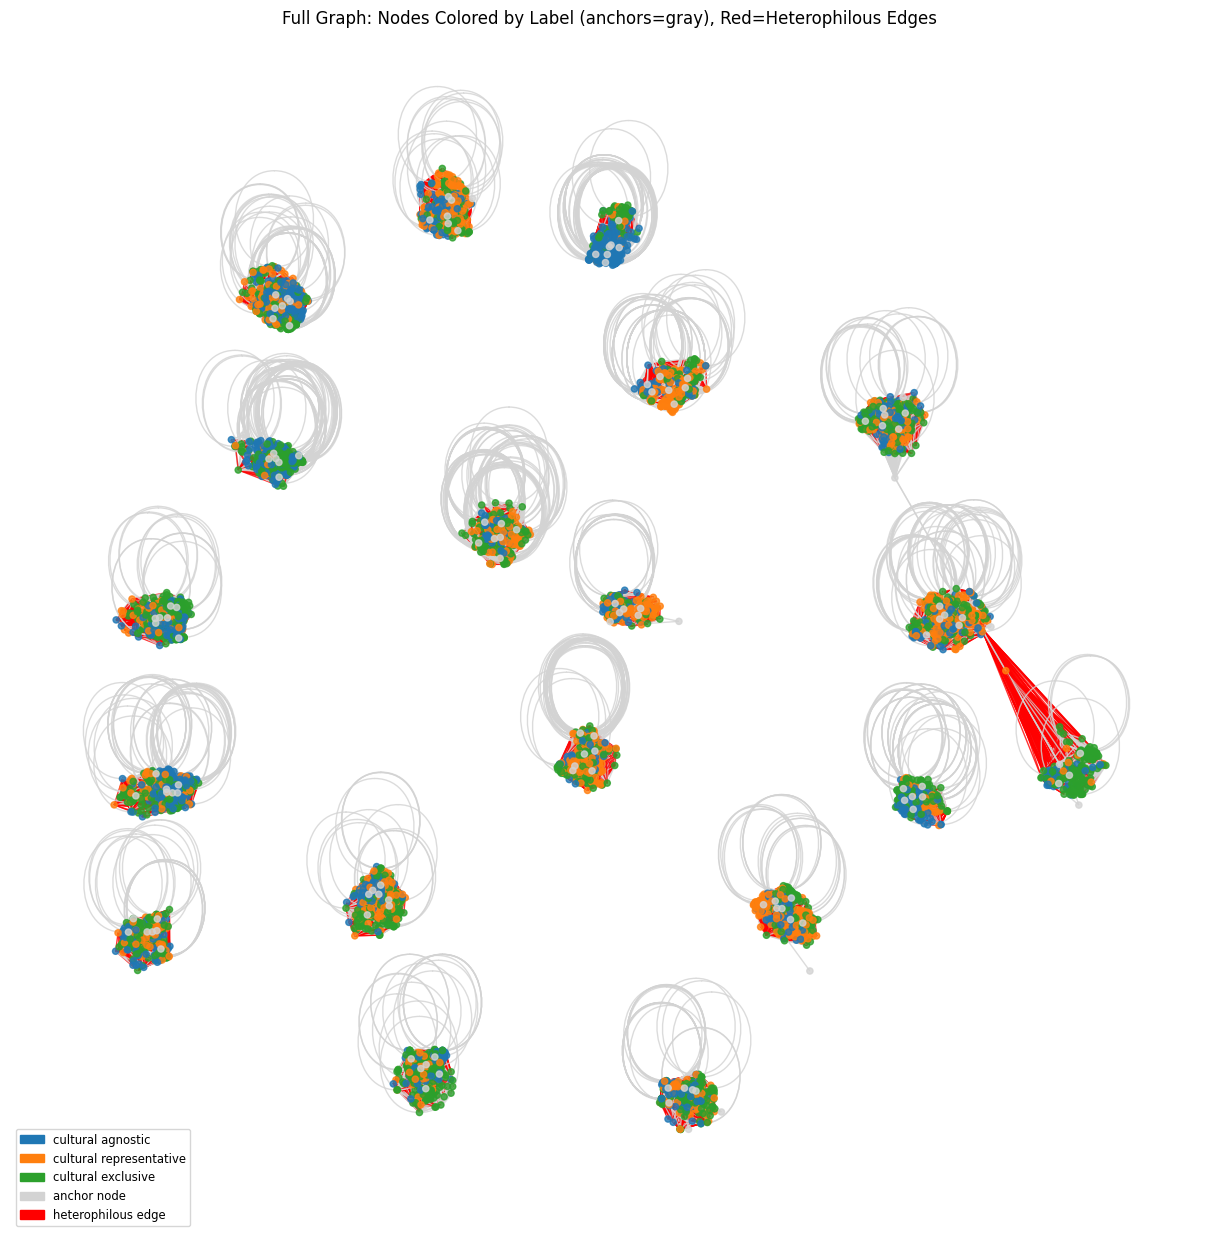

In [29]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# 1) Color maps for nodes.
label_names = {
    0: 'cultural agnostic',
    1: 'cultural representative',
    2: 'cultural exclusive',
   -1: 'anchor node'
}
label_colors = {
    0: 'tab:blue',
    1: 'tab:orange',
    2: 'tab:green',
   -1: 'lightgray'
}

node_colors = [
    label_colors[G.nodes[n]['y']]
    for n in G.nodes()
]

# 2) Edge colors for all edges.
edge_colors = []
for u, v in G.edges():
    y_u, y_v = G.nodes[u]['y'], G.nodes[v]['y']
    # only consider true item‐item heterophily
    if y_u >= 0 and y_v >= 0 and y_u != y_v:
        edge_colors.append('red')
    else:
        edge_colors.append('lightgray')

# 3) Plot the graph
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12,12))
nx.draw(
    G, pos,
    node_size=20,
    node_color=node_colors,
    edge_color=edge_colors,
    with_labels=False,
    alpha=0.8
)

# 4) Build legend.
legend_patches = [
    Patch(color=color, label=label_names[label])
    for label, color in label_colors.items()
]
legend_patches.append(Patch(color='red', label='heterophilous edge'))

plt.legend(
    handles=legend_patches,
    loc='lower left',
    fontsize='small',
    frameon=True
)
plt.title("Full Graph: Nodes Colored by Label (anchors=gray), Red=Heterophilous Edges")
plt.axis('off')
plt.show()


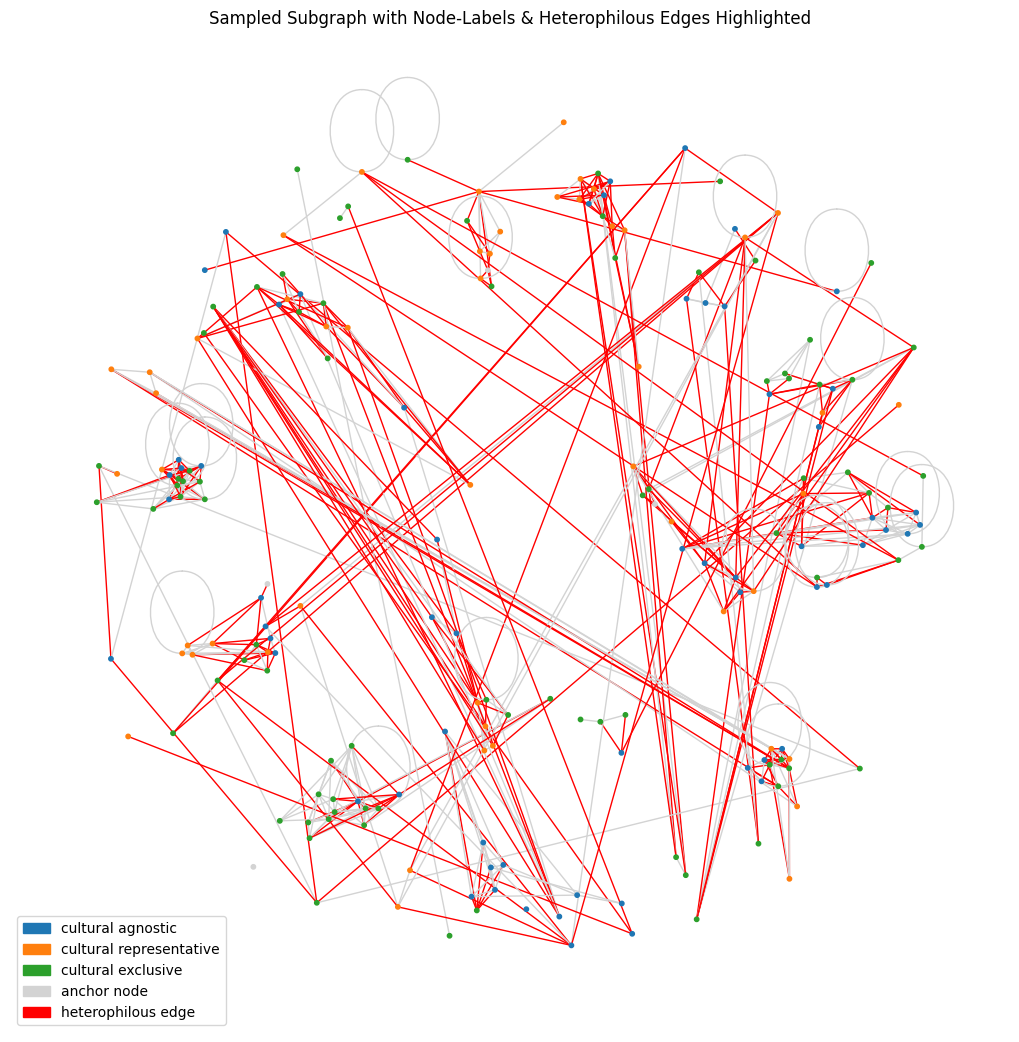

In [30]:
# Plot a subgraph of 200 random nodes.
# 1) Sample 200 random nodes.
sample_nodes = random.sample(list(G.nodes()), 200)
subG = G.subgraph(sample_nodes)
pos = nx.spring_layout(subG, seed=42)

# 1.5) Build color maps for the nodes.
pos = nx.spring_layout(subG, seed=42)
node_colors = [ label_colors[G.nodes[n]['y']] for n in subG.nodes() ]

# 1.75) Build color maps for the edges.
edge_colors = [
    'red' if G.nodes[u]['y'] != G.nodes[v]['y'] else 'lightgray'
    for u, v in subG.edges()
]

# 2) Draw the subgraph.
plt.figure(figsize=(10, 10))
nx.draw(subG, pos,
        node_size=10,
        node_color=node_colors,
        edge_color=edge_colors,
        with_labels=False)
plt.title("Sampled Subgraph with Node‐Labels & Heterophilous Edges Highlighted")
legend_patches = [
    Patch(color=color, label=label_names[label])
    for label, color in label_colors.items()
]
legend_patches.append(Patch(color='red', label='heterophilous edge'))
plt.legend(handles=legend_patches, loc='lower left')

plt.show()

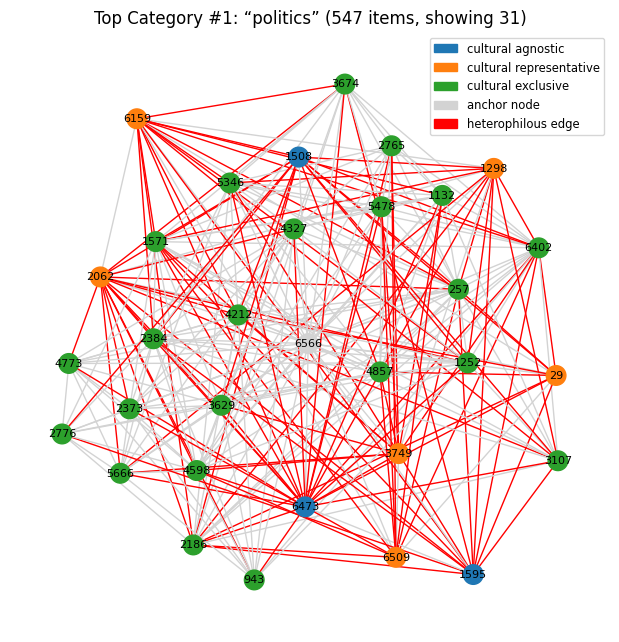

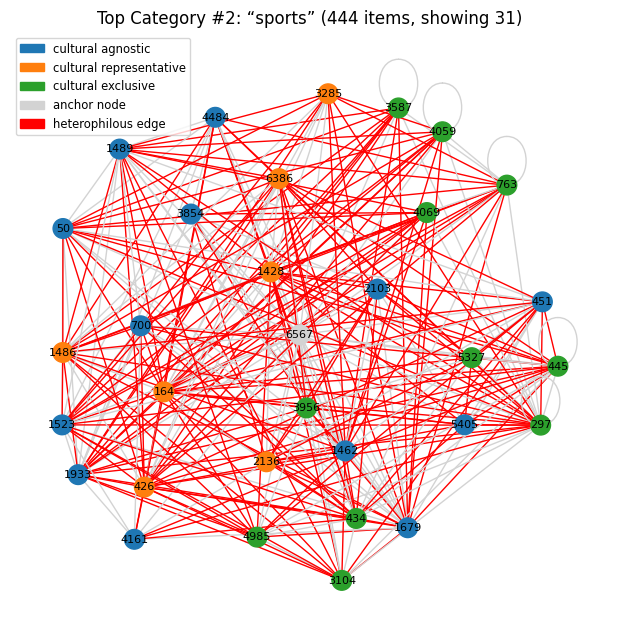

In [31]:
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from collections import Counter

# 1) Determine the two largest categories by raw item count.
cat_counts = Counter(df['category'])
top_categories = [cat for cat, _ in cat_counts.most_common(2)]

# 2) For each top category, grab its anchor and up to k items, then plot.
k = 31
for idx, cat in enumerate(top_categories, start=1):
    # — find the anchor node for this category (y == -1, category == cat)
    anchor_node = next(
        n for n, d in G.nodes(data=True)
        if d['category'] == cat and d['y'] == -1
    )
    # — get all item‐neighbors of that anchor
    items = [nbr for nbr in G.neighbors(anchor_node) if G.nodes[nbr]['y'] >= 0]
    sampled = random.sample(items, min(k, len(items)))
    sub_nodes = sampled + [anchor_node]
    subG = G.subgraph(sub_nodes)

    # — build colors
    node_colors = [
        label_colors[G.nodes[n]['y']] for n in subG.nodes()
    ]
    # only item–item edges could ever be heterophilous here (anchors all y=-1)
    edge_colors = [
        'red' if (G.nodes[u]['y'] >= 0 and G.nodes[v]['y'] >= 0 and
                  G.nodes[u]['y'] != G.nodes[v]['y'])
        else 'lightgray'
        for u, v in subG.edges()
    ]

    # — plot
    pos = nx.spring_layout(subG, seed=42)
    plt.figure(figsize=(6,6))
    nx.draw(
        subG, pos,
        node_size=200,
        node_color=node_colors,
        edge_color=edge_colors,
        with_labels=True,
        font_size=8
    )
    plt.title(f"Top Category #{idx}: “{cat}” ({len(items)} items, showing {len(sampled)})")

    # — legend (including anchors)
    legend_elems = [
        Patch(color=label_colors[l], label=name)
        for l, name in label_names.items()
    ]
    legend_elems.append(Patch(color='red', label='heterophilous edge'))
    plt.legend(handles=legend_elems, loc='best', fontsize='small')
    plt.axis('off')
    plt.show()


##### 2.1.2: DEFINE UTILS FUNCTIONS & BASIC PARAMS

In [32]:
def setup_training(data, seed = 42):
    """
    Utils function to set random seeds, moves data to the appropriate device, computes class weights
    for imbalanced cross‑entropy.
    """

    # 1) Set seeds for reproducibility.
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False
    os.environ["PYTHONHASHSEED"]       = str(seed)

    # 2) Device & move data.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data   = data.to(device)

    # 3) Compute class weights for imbalanced cross-entropy.
    train_y      = data.y[data.train_mask]
    class_counts = torch.bincount(train_y)
    # Inverse frequency.
    class_weights = 1.0 / (class_counts.float() + 1e-6)
    # Re‑scale so weights sum to #classes.
    class_weights = class_weights / class_weights.sum() * class_counts.numel()
    class_weights = class_weights.to(device)

    return device, data, class_weights


In [33]:
# Setup the training.
device, data, class_weights = setup_training(tdidf_graph_data, seed=42)

# Basic Params.
patience       = 50
best_val_loss  = float('inf')
epochs_no_imp  = 0
max_epochs     = 500
best_state     = None

In [34]:
def train_model(model, data, class_weights, patience, max_epochs):

    # Set basic info.
    best_val_loss = float('inf')
    epochs_no_imp = 0
    best_state    = None

    # Optimizer, Scheduler & Early Stopping setup.
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=1e-3,
                                weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=50,
                                                gamma=0.5)

    for epoch in range(1, max_epochs+1):

        # Training step.
        model.train()
        optimizer.zero_grad()
        out   = model(data.x, data.edge_index)
        loss  = F.cross_entropy(out[data.train_mask],
                                data.y[data.train_mask],
                                weight=class_weights)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Validation step.
        model.eval()
        with torch.no_grad():
            logits     = model(data.x, data.edge_index)
            val_logits = logits[data.val_mask]
            val_labels = data.y[data.val_mask]
            val_loss   = F.cross_entropy(val_logits, val_labels).item()

        # Check Early Stopping.
        if val_loss + 1e-4 < best_val_loss:
            best_val_loss = val_loss
            epochs_no_imp = 0
            best_state    = model.state_dict()
        else:
            epochs_no_imp += 1
            if epochs_no_imp >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

        # Print results every 10 epochs.
        if epoch % 10 == 0:
            # compute metrics
            preds = val_logits.argmax(dim=1)
            acc   = (preds == val_labels).float().mean().item()
            y_t   = val_labels.cpu().numpy()
            y_p   = preds.cpu().numpy()
            prec  = precision_score(y_t, y_p, average='macro', zero_division=0)
            rec   = recall_score(   y_t, y_p, average='macro', zero_division=0)
            f1    = f1_score(       y_t, y_p, average='macro', zero_division=0)
            ppl   = torch.exp(torch.tensor(val_loss)).item()

            print(f"[Epoch {epoch:03d}] "
                  f"Train Loss: {loss:.4f}  "
                  f"Val Loss:   {val_loss:.4f}  "
                  f"Val Acc:    {acc:.4f}  "
                  f"Prec:       {prec:.4f}  "
                  f"Rec:        {rec:.4f}  "
                  f"F1:         {f1:.4f}  "
                  f"PPL:        {ppl:.2f}")

    return best_state, best_val_loss


In [35]:
def evaluate_model(model, data, best_state, best_val_loss):

    # Loading the model and put it into evaluation mode.
    model.load_state_dict(best_state)
    model.eval()

    # Evaluate.
    with torch.no_grad():
        logits     = model(data.x, data.edge_index)[data.val_mask]
        labels     = data.y[data.val_mask]
        preds      = logits.argmax(dim=1)
        acc        = (preds == labels).float().mean().item()
        y_t        = labels.cpu().numpy()
        y_p        = preds.cpu().numpy()
        prec       = precision_score(y_t, y_p, average='macro', zero_division=0)
        rec        = recall_score(   y_t, y_p, average='macro', zero_division=0)
        f1         = f1_score(       y_t, y_p, average='macro', zero_division=0)
        ppl        = torch.exp(torch.tensor(best_val_loss)).item()

    print(f"\nBest Val Loss: {best_val_loss:.4f}")
    print(f"Final Val Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, "
          f"F1: {f1:.4f}, PPL: {ppl:.2f}")

    return {'acc':acc, 'prec':prec, 'rec':rec, 'f1':f1, 'ppl':ppl}

##### 2.1.2: GCN ("GRAPH CONVOLUTIONAL NETWORK")

In [36]:
# 3‑layer GCN Model (1 hidden) with residual + BatchNorm.
class GCN(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, dropout=0.5):
        super().__init__()
        # 1) Input layer.
        self.conv1   = GCNConv(in_dim, hid_dim)
        self.bn1     = BatchNorm1d(hid_dim)

        # 2) Hidden layer.
        self.conv2   = GCNConv(hid_dim, hid_dim)
        self.bn2     = BatchNorm1d(hid_dim)

        # 3) Output layer.
        self.conv3   = GCNConv(hid_dim, out_dim)

        # 4) Dropout layer.
        self.dropout = Dropout(dropout)

        # 5) Residual (skip).
        self.res_lin = Linear(in_dim, out_dim)

    def forward(self, x, edge_index):
        # Original input for residual skip.
        x0 = x

        # First layer.
        x = self.conv1(x, edge_index)
        x = self.bn1(x).relu()
        x = self.dropout(x)

        # Hidden layer.
        x = self.conv2(x, edge_index)
        x = self.bn2(x).relu()
        x = self.dropout(x)

        # Output layer.
        x = self.conv3(x, edge_index)

        # Residual skip from input.
        return x + self.res_lin(x0)


In [37]:
# 1) Instantiate GCN Model.
GCN_model = GCN(in_dim = tdidf_graph_data.x.size(1),
                hid_dim=64,
                out_dim = 3,
                dropout=0.5).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
    GCN_model, tdidf_graph_data, class_weights, patience, max_epochs
)

# 3) Evaluation of the Model.
metrics = evaluate_model(GCN_model, tdidf_graph_data, best_state, best_val_loss)

[Epoch 010] Train Loss: 1.0583  Val Loss:   1.0801  Val Acc:    0.3967  Prec:       0.4642  Rec:        0.3396  F1:         0.2002  PPL:        2.95
[Epoch 020] Train Loss: 0.9808  Val Loss:   1.0686  Val Acc:    0.4867  Prec:       0.6006  Rec:        0.4308  F1:         0.3690  PPL:        2.91
[Epoch 030] Train Loss: 0.9489  Val Loss:   1.0544  Val Acc:    0.5100  Prec:       0.5617  Rec:        0.4627  F1:         0.4317  PPL:        2.87
[Epoch 040] Train Loss: 0.9350  Val Loss:   1.0364  Val Acc:    0.5000  Prec:       0.5629  Rec:        0.4551  F1:         0.4273  PPL:        2.82
[Epoch 050] Train Loss: 0.9231  Val Loss:   1.0132  Val Acc:    0.4867  Prec:       0.5522  Rec:        0.4414  F1:         0.4089  PPL:        2.75
[Epoch 060] Train Loss: 0.9169  Val Loss:   0.9968  Val Acc:    0.4967  Prec:       0.4930  Rec:        0.4566  F1:         0.4326  PPL:        2.71
[Epoch 070] Train Loss: 0.9121  Val Loss:   0.9840  Val Acc:    0.5200  Prec:       0.5038  Rec:        0.

##### 2.1.3: GAT("GRAPH ATTENTION NETWORK")

In [38]:
# 3‑layer GAT Model (1 hidden) with residual + BatchNorm.
class GAT(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim,
                 heads=4, dropout=0.5):
        super().__init__()
        # 1) Input layer.
        self.conv1 = GATConv(in_dim, hid_dim, heads=heads, dropout=dropout)
        self.bn1   = BatchNorm1d(hid_dim * heads)

        # 2) Hidden layer.
        self.conv2 = GATConv(hid_dim * heads, hid_dim, heads=heads, dropout=dropout)
        self.bn2   = BatchNorm1d(hid_dim * heads)

        # 3) Output layer.
        self.conv3 = GATConv(hid_dim * heads, out_dim, heads=1, concat=False, dropout=dropout)

        # 4) Dropout layer.
        self.dropout = Dropout(dropout)

        # 5) Residual (skip).
        self.res_lin = Linear(in_dim, out_dim)

    def forward(self, x, edge_index):
        # Original input for residual skip.
        x0 = x

        # First layer.
        x = self.conv1(x, edge_index)
        x = self.bn1(x).relu()
        x = self.dropout(x)

        # Hidden layer.
        x = self.conv2(x, edge_index)
        x = self.bn2(x).relu()
        x = self.dropout(x)

        # Output layer.
        x = self.conv3(x, edge_index)

        # Residual skip from input.
        return x + self.res_lin(x0)


In [39]:
# 1) Instantiate GCN Model.
GAT_model = GAT(in_dim = tdidf_graph_data.x.size(1),
                hid_dim=64,
                out_dim = 3,
                dropout=0.5).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
    GAT_model, tdidf_graph_data, class_weights, patience, max_epochs
)

# 3) Evaluation of the Model.
metrics = evaluate_model(GAT_model, tdidf_graph_data, best_state, best_val_loss)

[Epoch 010] Train Loss: 1.0165  Val Loss:   1.0819  Val Acc:    0.4867  Prec:       0.3352  Rec:        0.4274  F1:         0.3571  PPL:        2.95
[Epoch 020] Train Loss: 0.9784  Val Loss:   1.0647  Val Acc:    0.4000  Prec:       0.3818  Rec:        0.3427  F1:         0.2069  PPL:        2.90
[Epoch 030] Train Loss: 0.9583  Val Loss:   1.0525  Val Acc:    0.4467  Prec:       0.3475  Rec:        0.3874  F1:         0.2960  PPL:        2.86
[Epoch 040] Train Loss: 0.9415  Val Loss:   1.0449  Val Acc:    0.5067  Prec:       0.4311  Rec:        0.4484  F1:         0.3877  PPL:        2.84
[Epoch 050] Train Loss: 0.9357  Val Loss:   1.0368  Val Acc:    0.5367  Prec:       0.5738  Rec:        0.5075  F1:         0.4971  PPL:        2.82
[Epoch 060] Train Loss: 0.9193  Val Loss:   1.0280  Val Acc:    0.5000  Prec:       0.5385  Rec:        0.4802  F1:         0.4690  PPL:        2.80
[Epoch 070] Train Loss: 0.9174  Val Loss:   1.0327  Val Acc:    0.4467  Prec:       0.5103  Rec:        0.

##### 2.1.4: GRAPHSAGE

In [40]:
# 3‑layer GraphSAGE Model (1 hidden) with residual + BatchNorm.
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, dropout=0.5):
        super().__init__()
        # 1) Input layer.
        self.conv1   = SAGEConv(in_dim, hid_dim)
        self.bn1     = BatchNorm1d(hid_dim)

        # 2) Hidden layer.
        self.conv2   = SAGEConv(hid_dim, hid_dim)
        self.bn2     = BatchNorm1d(hid_dim)

        # 3) Output layer.
        self.conv3   = SAGEConv(hid_dim, out_dim)

        # 4) Dropout layer.
        self.dropout = Dropout(dropout)

        # 5) Residual (skip).
        self.res_lin = Linear(in_dim, out_dim)

    def forward(self, x, edge_index):
        # Original input for residual skip.
        x0 = x

        # First layer.
        x = self.conv1(x, edge_index)
        x = self.bn1(x).relu()
        x = self.dropout(x)

        # Hidden layer.
        x = self.conv2(x, edge_index)
        x = self.bn2(x).relu()
        x = self.dropout(x)

        # Output layer.
        x = self.conv3(x, edge_index)

        # Residual skip from input.
        return x + self.res_lin(x0)


In [41]:
# 1) Instantiate GCN Model.
GraphSAGE_model = GraphSAGE(in_dim = tdidf_graph_data.x.size(1),
                hid_dim=64,
                out_dim = 3,
                dropout=0.5).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
    GraphSAGE_model, tdidf_graph_data, class_weights, patience, max_epochs
)

# 3) Evaluation of the Model.
metrics = evaluate_model(GraphSAGE_model, tdidf_graph_data, best_state, best_val_loss)

[Epoch 010] Train Loss: 0.8707  Val Loss:   1.0821  Val Acc:    0.3900  Prec:       0.1300  Rec:        0.3333  F1:         0.1871  PPL:        2.95
[Epoch 020] Train Loss: 0.7285  Val Loss:   1.0612  Val Acc:    0.4167  Prec:       0.3576  Rec:        0.3684  F1:         0.2532  PPL:        2.89
[Epoch 030] Train Loss: 0.6265  Val Loss:   1.0193  Val Acc:    0.5200  Prec:       0.6388  Rec:        0.4988  F1:         0.4283  PPL:        2.77
[Epoch 040] Train Loss: 0.5417  Val Loss:   0.9520  Val Acc:    0.5967  Prec:       0.6340  Rec:        0.5896  F1:         0.5423  PPL:        2.59
[Epoch 050] Train Loss: 0.4755  Val Loss:   0.8619  Val Acc:    0.6200  Prec:       0.6072  Rec:        0.6079  F1:         0.5803  PPL:        2.37
[Epoch 060] Train Loss: 0.4413  Val Loss:   0.7934  Val Acc:    0.6533  Prec:       0.6346  Rec:        0.6395  F1:         0.6251  PPL:        2.21
[Epoch 070] Train Loss: 0.4139  Val Loss:   0.7801  Val Acc:    0.6467  Prec:       0.6245  Rec:        0.

##### 2.1.5: GIN ("GRAPH ISOMORPHISM NETWORK")  

In [42]:
# 3‑layer GIN Model (1 hidden) with residual + BatchNorm.
class GIN(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, dropout=0.5):
        super().__init__()
        # 1) Input layer.
        self.conv1   = GINConv(Sequential(
            Linear(in_dim, hid_dim), ReLU(),
            Linear(hid_dim, hid_dim), ReLU()
        ))
        self.bn1     = BatchNorm1d(hid_dim)

        # 2) Hidden layer.
        self.conv2   = GINConv(Sequential(
            Linear(hid_dim, hid_dim), ReLU(),
            Linear(hid_dim, hid_dim), ReLU()
        ))
        self.bn2     = BatchNorm1d(hid_dim)

        # 3) Output layer.
        self.conv3   = GINConv(Sequential(
            Linear(hid_dim, hid_dim), ReLU(),
            Linear(hid_dim, out_dim),   ReLU()
        ))

        # 4) Dropout layer.
        self.dropout = Dropout(dropout)

        # 5) Residual (skip).
        self.res_lin = Linear(in_dim, out_dim)

    def forward(self, x, edge_index):
        # Original input for residual skip.
        x0 = x

        # First layer.
        x = self.conv1(x, edge_index)
        x = self.bn1(x).relu()
        x = self.dropout(x)

        # Hidden layer.
        x = self.conv2(x, edge_index)
        x = self.bn2(x).relu()
        x = self.dropout(x)

        # Output layer.
        x = self.conv3(x, edge_index)

        # Residual skip from input.
        return x + self.res_lin(x0)


In [43]:
# 1) Instantiate GCN Model.
GIN_model = GIN(in_dim = tdidf_graph_data.x.size(1),
                hid_dim=64,
                out_dim = 3,
                dropout=0.5).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
    GIN_model, tdidf_graph_data, class_weights, patience, max_epochs
)

# 3) Evaluation of the Model.
metrics = evaluate_model(GIN_model, tdidf_graph_data, best_state, best_val_loss)

[Epoch 010] Train Loss: 1.1270  Val Loss:   1.1591  Val Acc:    0.2967  Prec:       0.4325  Rec:        0.3373  F1:         0.2769  PPL:        3.19
[Epoch 020] Train Loss: 1.6831  Val Loss:   1.1418  Val Acc:    0.4700  Prec:       0.5047  Rec:        0.4800  F1:         0.4706  PPL:        3.13
[Epoch 030] Train Loss: 1.0674  Val Loss:   1.0595  Val Acc:    0.5500  Prec:       0.5781  Rec:        0.5571  F1:         0.5431  PPL:        2.88
[Epoch 040] Train Loss: 1.0325  Val Loss:   1.0448  Val Acc:    0.5733  Prec:       0.5722  Rec:        0.5702  F1:         0.5642  PPL:        2.84
[Epoch 050] Train Loss: 1.0229  Val Loss:   1.0307  Val Acc:    0.5633  Prec:       0.5520  Rec:        0.5562  F1:         0.5502  PPL:        2.80
[Epoch 060] Train Loss: 1.0180  Val Loss:   1.0249  Val Acc:    0.5633  Prec:       0.5501  Rec:        0.5547  F1:         0.5490  PPL:        2.79
[Epoch 070] Train Loss: 1.0137  Val Loss:   1.0201  Val Acc:    0.5600  Prec:       0.5477  Rec:        0.

##### 2.1.6: SHEAF NEURAL NETWORKS

**INTERPRETING EDGE HOMOPHILY VS HERETOPHILY**

We also decided to look at the degree of **Heretophily** that our graph has. Indeed, if >0.5, this means that maybe a **Sheaf Neural Network** could better help.

- **Edge Homophily:** The fraction of edges in the graph that connect nodes **of the same class**.  Here we have:
  - **High Homophily (close to 1.0)**: This means that **most neighbors share the same label**.  
  - **Standard/Low Homophily (<0.5)**: Standard GNNs (e.g. GCN, GAT) assume homophily: they smooth a node's features with its neighbors'.

- **Edge Heterophily**  
  The fraction of edges that connect nodes **of different classes**. When most edges cross labels, smoothing can actually *mix* conflicting signals, hurting performance. This is of course defined as:
  $$\text{Heterophily} = 1 − \text{Homophily}$$


In [44]:
def compute_edge_homophily(edge_index, labels):
    """
    Compute the fraction of edges in an undirected graph that connect nodes of the same label.
    """

    edge_index = edge_index.cpu()
    labels     = labels.cpu()

    # Count each undirected edge and make the mask.
    u, v = edge_index
    # print("u is: ", u)
    # print("v is: ", v)
    mask = u < v
    u, v = u[mask], v[mask]

    # Compare the labels.
    same = (labels[u] == labels[v]).sum().item()
    total = mask.sum().item()

    # homophily:  (# same‑label edges) / (# total undirected edges)
    return same / total if total > 0 else 0.0

def compute_edge_heterophily(edge_index, labels):
    """
    Compute the fraction of edges in an undirected graph that connect nodes of different label.
    (This is simply 1 − homophily).
    """
    h = compute_edge_homophily(edge_index, labels)
    return 1.0 - h

In [45]:
# Compute heterophily for the TD-IDF Graph.
homophily = compute_edge_homophily(tdidf_graph_data.edge_index, tdidf_graph_data.y)
heterophily = compute_edge_heterophily(tdidf_graph_data.edge_index, tdidf_graph_data.y)

print(f"Edge homophily   = {homophily:.4f}")
print(f"Edge heterophily = {heterophily:.4f}")

Edge homophily   = 0.4213
Edge heterophily = 0.5787


**SHEAF NEURAL NETWORK (SheafNN)**

*References: https://proceedings.neurips.cc/paper_files/paper/2022/file/75c45fca2aa416ada062b26cc4fb7641-Paper-Conference.pdf*.

The **SheafNN** we decided to employ is a **three-layer graph architecture** in which each layer performs a _learned diffusion_ over a **cellular sheaf** on the graph. More concretely, given:  
- A graph $G=(V,E)$ with $|V|=N$ nodes and edges $E$,  
- Node features $x\in\mathbb{R}^{N\times F}$,  
- A learnable **Restriction Map** of dimension $m$,  
- A per layer step size $\tau$,  

I have that each **Sheaf block** computes:

1. **Linear Embedding**: With $D$ is the output dimension of this layer.
   $$
     h \;=\;\mathrm{Linear}(x)\;\in\mathbb{R}^{N\times D}\,,
   $$  
   
2. **Restriction Maps Prediction**: For each edge $e=(u\to v)$, we extract the corresponding row indices $(u,v)$ and we then form the concatenated features  
   $$
     [h_u\Vert h_v]\;\in\;\mathbb{R}^{2D},
   $$  
   After that, we pass them through a small MLP $\mathit{sheaf\_learner}$ to get:
   $$
     \sigma_{u\to v} \;=\;\tanh\bigl(\mathit{sheaf\_learner}([h_u\Vert h_v])\bigr)\;\in\mathbb{R}^m.
   $$

3. **Sheaf Laplacian $\Delta_F$ Construction**: By defining the _sheafaadjacency_ entry and the degree as follows:
   $$
     (A_F)_{uv}
     \;=\; \langle\sigma_{u\to v},\,\sigma_{v\to u}\rangle
   $$  
    
   $\displaystyle D_u=\sum_{(u\to v)}\|\sigma_{u\to v}\|^2$.

   We can express the Sheaf Laplacian as follows, stored in sparse COO format.  
   $$
     \Delta_F \;=\; I \;-\; D^{-\tfrac12}\,A_F\,D^{-\tfrac12}
   $$

4. **Sheaf Diffusion Update**: After that, each layer adds a **residual bypass**, followed by **GraphNorm**, **ReLU**, and **Dropout**.  Stacking three of these blocks yields the final SheafNN:
   $$
     x'\;=\; h\;-\;\tau\,\Delta_F\,h\,.
   $$

   $$
      \begin{aligned}
        h^{(1)} &= \mathrm{SheafConv}(x)\,,
        &x^{(1)} &= \mathrm{ReLU}\bigl(\mathit{GraphNorm}(h^{(1)} + W_{\mathrm{res}}^{(1)}\,x)\bigr)\\
        h^{(2)} &= \mathrm{SheafConv}(x^{(1)})\,,
        &x^{(2)} &= \mathrm{ReLU}\bigl(\mathit{GraphNorm}(h^{(2)} + W_{\mathrm{res}}^{(2)}\,x^{(1)})\bigr)\\
        h^{(3)} &= \mathrm{SheafConv}(x^{(2)})\,,
        &\;y\;&=\;h^{(3)} + W_{\mathrm{res}}^{(3)}\,x^{(2)}\,.
      \end{aligned}
   $$

This architecture we built learns **edge-conditioned** diffusion kernels (the sheaf restriction maps), allowing it to adapt to **heterophilic** graphs and to mitigate **oversmoothing** by learning a rich, multi-dimensional “geometry” (the cellular sheaf) on top of the original graph.  


In [46]:
class SheafConvLayer(nn.Module):

    def __init__(self, in_dim, out_dim, edge_index, map_dim=16, step_size=1.0):
        super().__init__()
        # edge_index is a [2, E] tensor defining graph connectivity.
        self.edge_index = edge_index
        # step_size is a learnable parameter to scale the Laplacian update.
        self.step_size = nn.Parameter(torch.tensor(step_size))
        # linear projection from input feature to output dimension.
        self.linear = Linear(in_dim, out_dim)
        # The sheaf_learner predicts restriction maps for each edge.
        # The input is the concatenated features of u and v (size 2*out_dim).
        # The output is map_dim, that is used to build the sheaf laplacian.
        self.sheaf_learner = Linear(2*out_dim, map_dim, bias=False)
        # Buffers to store reverse-edge indices for Laplacian building.
        self.register_buffer('left_idx',  None)
        self.register_buffer('right_idx', None)
        # Precompute index mappings for reverse edges.
        self._precompute_indices()


    def _precompute_indices(self):
        # Compute for each directed edge (u->v) the index of its reverse (v->u).
        ei  = self.edge_index.cpu().numpy()
        rev = { (u,v):i for i,(u,v) in enumerate(zip(*ei)) }
        L, R = [], []
        # For each edge, we find matching reverse edge index or use itself.
        for i,(u,v) in enumerate(zip(*ei)):
            L.append(i)
            R.append(rev.get((v,u), i))
        dev = self.edge_index.device
        self.left_idx  = torch.tensor(L, dtype=torch.long, device=dev)
        self.right_idx = torch.tensor(R, dtype=torch.long, device=dev)

    def predict_restriction_maps(self, h):
        # Given the node features h (of dimension [N, out_dim]), we predict per-edge maps.
        row, col = self.edge_index
        hu = h[row]   # The features of source nodes (dimension [E, out_dim]).
        hv = h[col]   # The features of target nodes (dimension [E, out_dim]).
        # Let's then concatenate source and target nodes' features and pass through the sheaf_learner.
        r  = self.sheaf_learner(torch.cat([hu, hv], dim=1))  # [E, map_dim]
        # Let's bound the maps in [-1, 1].
        return torch.tanh(r)

    def build_laplacian(self, maps, N):
        """
        We build the sheaf Laplacian L_F = I - D^{-1/2} A_F D^{-1/2}.
        - where A_F(u,v) = <σ_u→v, σ_v→u> is the inner product of maps.
        - maps: (of dimension [E, map_dim]) is the restriction maps for each directed edge.
        - N: number of nodes in the graph.
        """
        row, col = self.edge_index
        # Let's gather forward and reverse maps (both of dimension [E, map_dim]).
        lm = maps[self.left_idx]
        rm = maps[self.right_idx]
        # The off-diagonal weight for each edge is: - <lm, rm>.
        off = -(lm * rm).sum(dim=1)            # (of dimension [E])
        # The degree per node: sum of squared map norms.
        D   = scatter_add((maps**2).sum(dim=1), row, dim=0, dim_size=N)  # (of dimension [N])
        d_is = (D + 1e-6).pow(-0.5) # D^{-1/2} with epsilon stability.

        # Construct sparse indices for COO(cooridnate) matrix: diagonal and off-diagonals.
        idx_diag = torch.arange(N, device=maps.device)
        idx = torch.cat([
            torch.stack([idx_diag, idx_diag], dim=0), # Identity entries.
            self.edge_index                           # Off-diagonal entries.
        ], dim=1)                                     # (The dimension is [2, N+E])

        # The values are: 1 for diag, d_i * off_uv * d_j for edges.
        val_diag = torch.ones(N, device=maps.device)
        val_off  = d_is[row] * off * d_is[col] # (The dimension is [E]).
        vals     = torch.cat([val_diag, val_off], dim=0)  # (The dimension is [N+E]).

        # Return sparse Laplacian tensor.
        return torch.sparse_coo_tensor(idx, vals, (N, N))

    def forward(self, x, edge_index=None):
        """
        Forward pass steps:
          1) Linear transform to get h = W x.
          2) Predict maps sigma on edges.
          3) Build sheaf Laplacian L_F.
          4) Update features: h - step_size * L_F h.
        """

        if edge_index is not None:
          # Allow dynamic graphs by resetting edge_index.
          self.edge_index = edge_index
          self._precompute_indices()

        # 1) Linear projection.
        h = self.linear(x)     # (The dimension is [N, out_dim])

        # 2) Predict restriction maps.
        maps = self.predict_restriction_maps(h)     # (The dimension is [E, map_dim])

        # 3) Build the Laplacian.
        L    = self.build_laplacian(maps, x.size(0)) # (The dimension is a sparse [N, N])

        # 4) Sheaf Update.
        return h - self.step_size * torch.sparse.mm(L, h)


class SheafCN(nn.Module):
    """
    Multi-layer Sheaf Network with:
      - Learnable restriction maps per layer.
      - Layer-wise residual connections.
      - GraphNorm, ReLU activation, and Dropout.
    """
    def __init__(self, in_dim, hid_dim, out_dim, edge_index,
                 map_dim=16, dropout=0.5, step_size=1.0):
        super().__init__()
        # Block1.
        self.conv1 = SheafConvLayer(in_dim,  hid_dim, edge_index,
                                    map_dim=map_dim, step_size=step_size)
        self.res1  = Linear(in_dim,  hid_dim)
        self.norm1 = GraphNorm(hid_dim)
        # Block2.
        self.conv2 = SheafConvLayer(hid_dim, hid_dim, edge_index,
                                    map_dim=map_dim, step_size=step_size)
        self.res2  = Linear(hid_dim, hid_dim)
        self.norm2 = GraphNorm(hid_dim)
        # Block3 (output block).
        self.conv3 = SheafConvLayer(hid_dim, out_dim, edge_index,
                                    map_dim=map_dim, step_size=step_size)
        self.res3  = Linear(hid_dim, out_dim)

        # Dropout applied after each norm+ReLU.
        self.dropout = Dropout(dropout)

    def forward(self, x, edge_index):

        # Block 1: sheaf conv + residual + norm + activation + dropout.
        h1 = self.conv1(x, edge_index)
        x  = h1 + self.res1(x)
        x  = self.norm1(x).relu()
        x  = self.dropout(x)
        # Block 2 (same as above).
        h2 = self.conv2(x, edge_index)
        x  = h2 + self.res2(x)
        x  = self.norm2(x).relu()
        x  = self.dropout(x)
        # Block 3 (Final output block (no norm/dropout)).
        h3 = self.conv3(x, edge_index)
        out = h3 + self.res3(x)

        return out # (dimension of [N, out_dim]).


In [ ]:
# 1) Instantiate the Model.
sheaf_model = SheafCN(
    in_dim     = tdidf_graph_data.x.size(1),
    hid_dim    = 64,
    out_dim    = tdidf_graph_data.y.max().item()+1,
    edge_index = tdidf_graph_data.edge_index,
    map_dim    = 16,
    dropout    = 0.5,
    step_size  = 0.5,
).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
      sheaf_model, tdidf_graph_data.to(device), class_weights.to(device), patience, max_epochs
  )

# 3) Evaluation of the Model.
metrics = evaluate_model(sheaf_model, tdidf_graph_data, best_state, best_val_loss)


[Epoch 010] Train Loss: 0.8702  Val Loss:   0.8223  Val Acc:    0.6333  Prec:       0.6180  Rec:        0.6205  F1:         0.6188  PPL:        2.28
[Epoch 020] Train Loss: 0.6561  Val Loss:   0.8126  Val Acc:    0.6400  Prec:       0.6179  Rec:        0.6216  F1:         0.6185  PPL:        2.25
[Epoch 030] Train Loss: 0.5503  Val Loss:   0.8255  Val Acc:    0.6267  Prec:       0.6012  Rec:        0.6041  F1:         0.6011  PPL:        2.28


#### 2.2: SENTENCE-TRANSFORMER CONTEXTUAL VECTOR

--------------------------
**CONTEXTUAL EMBEDDINGS**

To generate more meaningful **feature vectors** (in substitution to the naive *TD-IDF feature vector*, we employ a **Sentence Transformer** (using the ***all-mpnet-base-v2 model***) to compute **Contextual Embeddings**. We enhance the representation of the main node by encoding it into a dense vector that captures fine semantic nuances.

*WHY SENTENCE TRASNFORMER: all-mpnet-base-v2 model*

We choose **all-mpnet-base-v2 model** because it strikes an excellent balance between efficiency and the quality of contextual embeddings. Indeed:

- **BERT** adopts masked language modeling (MLM) for pre-training and is one of the most successful pre-training models. However BERT neglects dependency among predicted tokens. *BERT* and *RoBERTa* at their time set a new state-of-the-art performance (particularly on sentence-pair regression tasks like semantic textual similarity (STS)), but they however require that both sentences are fed into the network, causing a **massive computational overhead**. The construction of BERT makes it unsuitable for semantic similarity search. **Sentence-BERT (SBERT)** is a modification of the pretrained BERT network that use siamese and triplet network structures to derive semantically meaningful sentence embeddings that can be compared using cosine-similarity. This reduces the effort for finding the most similar pair from 65 hours with BERT / RoBERTa to about 5 seconds with SBERT, while maintaining the accuracy from BERT.
- **XLNet** introduces permuted language modeling (PLM) for pre-training to address this problem. However, XLNet does not leverage the full position information of a sentence and thus suffers from position discrepancy between pre-training and fine-tuning.
- **MPNet** inherits the advantages of BERT and XLNet and avoids their limitations. MPNet leverages the dependency among predicted tokens through permuted language modeling (vs. MLM in BERT), and takes auxiliary position information as input to make the model see a full sentence and thus reducing the position discrepancy (vs. PLM in XLNet). Also as concerns avg performances in terms of speed, we also have that this is fast w.r.t. the others.

For more info about model performances: https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

***(REFERENCES)***
- *BERT*: https://arxiv.org/abs/1810.04805
- *RoBERTa*: https://arxiv.org/abs/1907.11692
- *XLNet*: https://arxiv.org/abs/1906.08237
- *Sentence-BERT*: https://arxiv.org/abs/1908.10084
- *MPNet*: https://arxiv.org/abs/2004.09297



In [ ]:
# 1) Data Preparation and Split.
train_df = train_df.copy()
val_df   = validation_df.copy()
train_df['split'] = 'train'
val_df['split']   = 'val'
df = pd.concat([train_df, val_df], ignore_index=True)
df['train_mask'] = df['split'] == 'train'
df['val_mask']   = df['split'] == 'val'
n = len(df)

# 2) Build a NetworkX graph.
G = nx.Graph()
for i, row in df.iterrows():
    G.add_node(i,
               category    = row['category'],
               subcategory = row['subcategory'],
               train_mask  = bool(row['train_mask']),
               val_mask    = bool(row['val_mask'])
              )

# 2.1) Clique‐connect by category & subcategory.
for attr in ['category', 'subcategory']:
    for _, idxs in df.groupby(attr).groups.items():
        for u, v in itertools.combinations(idxs, 2):
            G.add_edge(u, v)

# 3) Computing Node Features (contextual embeddings with all-mpnet-base-v2).
model = SentenceTransformer('all-mpnet-base-v2')
texts = (df['name'] + " " + df['description']).tolist()
# Encode into dense embeddings (shape: [n, 768]).
embeddings = model.encode(texts, convert_to_numpy=True, show_progress_bar=True)

# 4) Label Encoding.
label_map = {
    'cultural agnostic':       0,
    'cultural representative': 1,
    'cultural exclusive':      2,
}
Y = df['label'].map(label_map).astype(int).values

# Stash x, y, and masks on nodes.
for i in range(n):
    G.nodes[i]['x']          = embeddings[i]
    G.nodes[i]['y']          = int(Y[i])
    G.nodes[i]['train_mask'] = G.nodes[i]['train_mask']
    G.nodes[i]['val_mask']   = G.nodes[i]['val_mask']

# Convert to torch_geometric.Data.
mpnet_graph_data = from_networkx(G)

# Fix necessary dtypes/names to PyG conventions.
mpnet_graph_data.x           = mpnet_graph_data.x.float()          # Shape: [n,768]
mpnet_graph_data.y           = mpnet_graph_data.y.long()           # Shape: [n]
mpnet_graph_data.train_mask  = mpnet_graph_data.train_mask.bool()  # Shape: [n]
mpnet_graph_data.val_mask    = mpnet_graph_data.val_mask.bool()    # Shape: [n]

print(mpnet_graph_data)


##### 2.2.1: GCN

In [ ]:
# 1) Instantiate GCN Model.
GCN_model = GCN(in_dim = mpnet_graph_data.x.size(1),
                hid_dim=64,
                out_dim = 3,
                dropout=0.5).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
    GCN_model, mpnet_graph_data.to(device), class_weights.to(device), 100, 2000
)

# 3) Evaluation of the Model.
metrics = evaluate_model(GCN_model, mpnet_graph_data, best_state, best_val_loss)

#####2.2.2: GAT

In [ ]:
# 1) Instantiate GCN Model.
GAT_model = GAT(in_dim = mpnet_graph_data.x.size(1),
                hid_dim=64,
                out_dim = 3,
                dropout=0.5).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
    GAT_model, mpnet_graph_data.to(device), class_weights.to(device), 100, 2000
)

# 3) Evaluation of the Model.
metrics = evaluate_model(GAT_model, mpnet_graph_data, best_state, best_val_loss)

##### 2.2.3: GRAPHSAGE

In [ ]:
# 1) Instantiate GCN Model.
GraphSAGE_model = GraphSAGE(in_dim = mpnet_graph_data.x.size(1),
                hid_dim=64,
                out_dim = 3,
                dropout=0.5).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
    GraphSAGE_model, mpnet_graph_data.to(device), class_weights.to(device), 100, 2000
)

# 3) Evaluation of the Model.
metrics = evaluate_model(GraphSAGE_model, mpnet_graph_data, best_state, best_val_loss)

##### 2.2.4: GIN

In [ ]:
# 1) Instantiate GCN Model.
GIN_model = GIN(in_dim = mpnet_graph_data.x.size(1),
                hid_dim=64,
                out_dim = 3,
                dropout=0.5).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
    GIN_model, mpnet_graph_data.to(device), class_weights.to(device), 100, 2000
)

# 3) Evaluation of the Model.
metrics = evaluate_model(GIN_model, mpnet_graph_data, best_state, best_val_loss)

##### 2.2.5: SHEAFNN

In [ ]:
# 1) Instantiate the Model
sheaf_model = SheafCN(
    in_dim     = mpnet_graph_data.x.size(1),
    hid_dim    = 64,
    out_dim    = mpnet_graph_data.y.max().item()+1,
    edge_index = mpnet_graph_data.edge_index,
    map_dim    = 16,
    dropout    = 0.5,
    step_size  = 0.5,       # try 0.1,0.2,…
).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
      sheaf_model, mpnet_graph_data, class_weights, patience, max_epochs
  )

# 3) Evaluation of the Model.
metrics = evaluate_model(sheaf_model, mpnet_graph_data, best_state, best_val_loss)


#### 2.3: SimCLR Contrastive Embeddings Integration

As a further step, we decide to **augment** our **contextual embeddings**, obtained using the *MPNet* with a **SimCLR Contrastive Learning**, by performing the **MPNet SimCLR fine-tuning** and **re-encoding**. In fact, beyond simply using pre-trained MPNet to embed our “name+description” texts, we want to **sharpen the distances** between different classes and **tighten** examples of the same class. Classical MPNet embeddings are learned with unsupervised Masked Language Modeling, which may place semantically similar—but differently-labeled—texts too close together.  By adding a **SimCLR** contrastive learning stage, we:

1. **Inject in-batch negatives**: In this step, we will have that every other sample in a batch acts as a negative, amplifying inter-class repulsion.  
2. **Control repulsion via temperature**: We will have a scalar $\tau$ that “sharpens” or “softens” distinctions.  


**HOW SIMCLR WORKS**

1. **Augmented Views**  
   For each original text $t_i$, generate two noisy views:
   $$
     \tilde t_i^{(1)} = A(t_i),\quad \tilde t_i^{(2)} = A(t_i),
   $$
   where $A(\cdot)$ is a simple NLP augmentation.

2. **Encoding & Projection**  
   We pass each view through our fine‑tunable MPNet encoder $f_\theta$ (and optionally a small projection head $g_\phi$):
   $$
     h_i^{(k)} = f_\theta\bigl(\tilde t_i^{(k)}\bigr)\in\mathbb{R}^{768},\quad
     z_i^{(k)} = g_\phi\bigl(h_i^{(k)}\bigr)\in\mathbb{R}^{d'}.
   $$
   We then L2‑normalize:
   $$
     \mathbf{u}_i^{(k)} = \frac{z_i^{(k)}}{\|z_i^{(k)}\|}.
   $$

3. **NT‑Xent Loss**  
   In a batch of $N$ samples, we create $2N$ embeddings $\{\mathbf{u}_i^{(k)}\}_{i=1..N}^{k=1,2}$.  For each positive pair $(i,1)$ & $(i,2)$, define the loss
   $$
   \ell_i = -\log \frac
     {\exp\!\bigl(\mathrm{sim}(\mathbf{u}_i^{(1)},\mathbf{u}_i^{(2)})/\tau\bigr)}
     {\sum\limits_{\substack{j=1 \\ (j,q)\neq(i,1)}}^{N}
      \exp\!\bigl(\mathrm{sim}(\mathbf{u}_i^{(1)},\mathbf{u}_j^{(q)})/\tau\bigr)}
   \;+\;
   -\log \frac
     {\exp\!\bigl(\mathrm{sim}(\mathbf{u}_i^{(2)},\mathbf{u}_i^{(1)})/\tau\bigr)}
     {\sum\limits_{\substack{j=1 \\ (j,q)\neq(i,2)}}^{N}
      \exp\!\bigl(\mathrm{sim}(\mathbf{u}_i^{(2)},\mathbf{u}_j^{(q)})/\tau\bigr)},
   $$
   where
   $$
     \mathrm{sim}(\mathbf{a},\mathbf{b})
     = \frac{\mathbf{a}^\top\mathbf{b}}{\|\mathbf{a}\|\;\|\mathbf{b}\|},
     \quad \tau > 0 \ (\text{e.g. }0.5).
   $$
   The total batch loss is
   $$
     L = \frac{1}{2N} \sum_{i=1}^N \ell_i.
   $$

4. **Why This Boosts Heterophily**  
   - **Massive repulsion**: each unpaired sample acts as a negative, so texts from **different classes** are driven to the opposite ends of the unit sphere.  
   - **Sharper clusters**: positive pairs (augmented from the same text) collapse tightly, making same‑class clusters compact.  
   - **Farthest‑neighbor edges**: when we subsequently build edges based on **low** cosine similarity, those edges almost always connect **different** classes—injecting strong heterophilic structure.

In [ ]:
# PUT HERE YOUR WANDBAPI CODE:
# wandbapi = b3bce19a09c51bdf8a19eb3dc58f7c44de929e13

# 1) Data Preparation and Split.
train_df = train_df.copy()
val_df   = validation_df.copy()
train_df['split'] = 'train'
val_df['split']   = 'val'
df = pd.concat([train_df, val_df], ignore_index=True)
df['train_mask'] = df['split'] == 'train'
df['val_mask']   = df['split'] == 'val'
n = len(df)

# 2) Build a NetworkX graph.
G = nx.Graph()
for i, row in df.iterrows():
    G.add_node(i,
               category    = row['category'],
               subcategory = row['subcategory'],
               train_mask  = bool(row['train_mask']),
               val_mask    = bool(row['val_mask'])
              )

# 2.1) Clique‑connect by category & subcategory (homophilic edges).
for attr in ['category', 'subcategory']:
    for _, idxs in df.groupby(attr).groups.items():
        for u, v in itertools.combinations(idxs, 2):
            G.add_edge(u, v, edge_type=f"same_{attr}")

# 3) Contrastive fine‑tuning of MPNet (SimCSE style).
model = SentenceTransformer('all-mpnet-base-v2')
texts = (df['name'] + " " + df['description']).tolist()

# Label Encoding.
label_map = {
    'cultural agnostic':       0,
    'cultural representative': 1,
    'cultural exclusive':      2,
}
Y = df['label'].map(label_map).astype(int).values

# Build triplet examples: (anchor, positive, negative).
triplets = []
for i in range(n):

    # Positive: same label (excluding self).
    pos_idxs = np.where(df['label'].map(label_map).values == df['label'].map(label_map).values[i])[0].tolist()
    pos_idxs = [j for j in pos_idxs if j != i]
    if not pos_idxs:
        continue
    j = random.choice(pos_idxs)

    # Negative: different label.
    neg_idxs = np.where(df['label'].map(label_map).values != df['label'].map(label_map).values[i])[0]
    k = random.choice(neg_idxs.tolist())
    triplets.append(InputExample(texts=[texts[i], texts[j], texts[k]]))

# DataLoader for contrastive learning. Use margin-based TripletLoss.
contrastive_loader = DataLoader(triplets, shuffle=True, batch_size=16)
contrastive_loss   = losses.TripletLoss(model=model, triplet_margin=0.5)

# Fine‑tune MPNet for XX epochs.
model.fit(
    train_objectives=[(contrastive_loader, contrastive_loss)],
    epochs=3,
    warmup_steps=100
)

# 4) Compute contextual embeddings with the fine‑tuned model.
embeddings = model.encode(texts, convert_to_numpy=True, show_progress_bar=True)  # [n,768]

# 5) Stash features on nodes.
for i in range(n):
    G.nodes[i]['x']          = embeddings[i]
    G.nodes[i]['y']          = int(Y[i])
    G.nodes[i]['train_mask'] = G.nodes[i]['train_mask']
    G.nodes[i]['val_mask']   = G.nodes[i]['val_mask']

# 6) Convert to torch_geometric.Data.
contrastive_learning_data = from_networkx(G)
contrastive_learning_data.x           = contrastive_learning_data.x.float()          # [n,768]
contrastive_learning_data.y           = contrastive_learning_data.y.long()           # [n]
contrastive_learning_data.train_mask  = contrastive_learning_data.train_mask.bool()  # [n]
contrastive_learning_data.val_mask    = contrastive_learning_data.val_mask.bool()    # [n]

print(contrastive_learning_data)


In [ ]:
# Compute heterophily for the TD-IDF Graph.
homophily = compute_edge_homophily(contrastive_learning_data.edge_index, contrastive_learning_data.y)
heterophily = compute_edge_heterophily(contrastive_learning_data.edge_index, contrastive_learning_data.y)

print(f"Edge homophily   = {homophily:.4f}")
print(f"Edge heterophily = {heterophily:.4f}")

##### 2.3.1: GCN

In [ ]:
# 1) Instantiate GCN Model.
GCN_model = GCN(in_dim = contrastive_learning_data.x.size(1),
                hid_dim=64,
                out_dim = 3,
                dropout=0.5).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
    GCN_model, contrastive_learning_data.to(device), class_weights.to(device), 100, 2000
)

# 3) Evaluation of the Model.
metrics = evaluate_model(GCN_model, contrastive_learning_data, best_state, best_val_loss)

##### 2.3.2: GAT

In [ ]:
# 1) Instantiate GCN Model.
GAT_model = GAT(in_dim = contrastive_learning_data.x.size(1),
                hid_dim=64,
                out_dim = 3,
                dropout=0.5).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
    GAT_model, contrastive_learning_data.to(device), class_weights.to(device), 100, 2000
)

# 3) Evaluation of the Model.
metrics = evaluate_model(GAT_model, contrastive_learning_data, best_state, best_val_loss)

##### 2.3.3: GRAPHSAGE

In [ ]:
# 1) Instantiate GCN Model.
GraphSAGE_model = GraphSAGE(in_dim = contrastive_learning_data.x.size(1),
                hid_dim=64,
                out_dim = 3,
                dropout=0.5).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
    GraphSAGE_model, contrastive_learning_data.to(device), class_weights.to(device), 100, 2000
)

# 3) Evaluation of the Model.
metrics = evaluate_model(GraphSAGE_model, contrastive_learning_data, best_state, best_val_loss)

##### 2.3.4: GIN

In [ ]:
# 1) Instantiate GCN Model.
GIN_model = GIN(in_dim = contrastive_learning_data.x.size(1),
                hid_dim=64,
                out_dim = 3,
                dropout=0.5).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
    GIN_model, contrastive_learning_data.to(device), class_weights.to(device), 100, 2000
)

# 3) Evaluation of the Model.
metrics = evaluate_model(GIN_model, contrastive_learning_data, best_state, best_val_loss)

##### 2.3.5: SHEAFNN

In [ ]:
# 1) Instantiate the Model
sheaf_model = SheafCN(
    in_dim     = contrastive_learning_data.x.size(1),
    hid_dim    = 64,
    out_dim    = contrastive_learning_data.y.max().item()+1,
    edge_index = contrastive_learning_data.edge_index,
    map_dim    = 16,
    dropout    = 0.5,
    step_size  = 0.5,       # try 0.1,0.2,…
).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
      sheaf_model, contrastive_learning_data.to(device), class_weights.to(device), 50, 200
  )

# 3) Evaluation of the Model.
metrics = evaluate_model(sheaf_model, contrastive_learning_data, best_state, best_val_loss)


###### 2.3.5.1: STEP-SIZE ABLATION

In [ ]:
for step in [0.1, 0.2, 0.5, 1.0, 2.0, 3.0]:
    print(f"STEP-SIZE = {step}")
    # 1) Instantiate the Model
    sheaf_model = SheafCN(
          in_dim    = contrastive_learning_data.x.size(1),
          hid_dim   = 64,
          out_dim   = contrastive_learning_data.y.max().item()+1,
          edge_index= contrastive_learning_data.edge_index,
          dropout   = 0.5,
          step_size = step,
      ).to(device)

      # 2) Training the model.
    best_state, best_val_loss = train_model(
          sheaf_model, contrastive_learning_data.to(device), class_weights.to(device), patience, max_epochs
      )

      # 3) Evaluation of the Model.
    metrics = evaluate_model(sheaf_model, contrastive_learning_data, best_state, best_val_loss)
